# ESMM 简介

Entire Space Multi-task Model (ESMM)[1] 是阿里妈妈精准定向广告算法团队研发的新型多任务联合训练算法范式。

在诸如信息检索、推荐系统、在线广告投放系统等工业级的应用中准确预估转化率（post-click conversion rate，CVR）是至关重要的。例如，在电商平台的推荐系统中，最大化场景商品交易总额（GMV）是平台的重要目标之一，而GMV可以拆解为流量×点击率×转化率×客单价，可见转化率是优化目标的重要因子；从用户体验的角度来说准确预估的转换率被用来平衡用户的点击偏好与购买偏好。

传统的CVR预估任务通常采用类似于CTR预估的技术，比如最近很流行的深度学习模型。然而，有别于CTR预估任务，CVR预估任务面临一些特有的挑战：1) 样本选择偏差；2) 训练数据稀疏；3) 延迟反馈等。

ESMM模型利用用户行为序列数据在完整样本空间建模，避免了传统CVR模型经常遭遇的样本选择偏差和训练数据稀疏的问题，取得了显著的效果。另一方面，ESMM模型首次提出了利用学习CTR和CTCVR的辅助任务迂回学习CVR的思路。ESMM模型中的BASE子网络可以替换为任意的学习模型，因此ESMM的框架可以非常容易地和其他学习模型集成，从而吸收其他学习模型的优势，进一步提升学习效果，想象空间巨大。

## 文档内容说明
本文旨在介绍ESMM以及如何使用ESMM开源项目进行实际业务生产所用，阅读完成后，你可以了解到：

* ESMM的基本系统组成
* ESMM开源代码的运行和使用
* 应用ESMM到具体实践的方法

受限于篇幅以及主旨，以下内容本文不涉及，或请参阅相关文档：
* 公开数据集的下载、使用和授权
    * Ali-CCP：Alibaba Click and Conversion Prediction请参阅：[https://tianchi.aliyun.com/datalab/dataSet.html?dataId=408](https://tianchi.aliyun.com/datalab/dataSet.html?dataId=408)


## ESMM 适用的问题


<img src="assets/impression_click_buy.png"/>


ESMM 充分利用用户行为的序列模式，在 CTR 和 CTCVR 两项辅助任务的帮助下，优雅地解决了在实践中遇到的 CVR 建模 \$\textbf{SSB}\$ 和 \$\textbf{DS}\$ 的挑战。ESMM 可以很容易地推广到具有序列依赖性的用户行为(浏览、点击、加购、购买等)预估中，构建跨域多场景全链路预估模型。



<img src="assets/system_overview.png"/>

广告或推荐系统中，用户行为的系统链路可以表示为 \$召回 \rightarrow  粗排 \rightarrow 精排 \rightarrow 展现 \rightarrow 点击 \rightarrow 转化 \rightarrow 复购 \$ 的序列。通常我们在引擎请求的时候进行多阶段的综合排序并不断选取头部的子集传给下一级，最终在展现阶段返回给用户。每阶段任务的输入量级都会因为上一阶段任务经过系统筛选（比如 召回到粗排、粗排到精排、精排到展现）或者用户主动筛选（比如 展现到点击、点击到转化、转化到复购）而逐步减少。ESMM 适用于成熟的电商推荐或者广告全链路预估系统。我们也希望本文的读者或者使用者如果在ESMM应用的实践中有任何困难，可随时与我们联系：maxiao.mx@alibaba-inc.com

# ESMM 框架介绍

## 算法原理

ESMM 引入两个预估展现点击率（CTR）和展现后点击转化率（CTCVR）作为辅助任务。ESMM 将 pCVR 作为一个中间变量，并将其乘以 pCTR 得到 pCTCVR，而不是直接基于有偏的点击样本子集进行 CVR 模型训练。pCTCVR 和 pCTR 是在全空间中以所有展现样本估计的，因此衍生的 pCVR 也适用于全空间并且缓解了 \$\textbf{SSB}\$ 问题。此外，CVR 任务的特征表示网络与 CTR 任务共享，后者用更丰富的样本进行训练。这种参数共享遵循特征表示迁移学习范式，并为缓解 \$\textbf{DS}\$ 问题提供了显著的帮助。

## 全空间建模
pCTR和pCTCVR是ESMM在全空间实际预估的变量。这种乘法形式使得三个关联和共同训练的分类器能够在训练期间利用数据的序列模式并相互传递信息。ESMM的损失函数如下，它由 CTR 和 CTCVR 任务中的两个损失项组成，这些任务通过所有展现次数的样本进行计算。

\begin{equation}
\begin{split}
L(\theta*{cvr}, \theta*{ctr}) = \sum*{i=1}^N l(y\_i, f(\textbf{x}*i;\theta*{ctr})) + \sum*{i=1}^N l(y\_i&z\_i, f(\textbf{x}*i;\theta*{ctr}) \times f(\textbf{x}*i;\theta*{cvr}))
\end{split}
\end{equation}

其中 \$\theta\_{ctr}\$ 和 \$\theta\_{cvr}\$ 是 CTR 和 CVR 网络的参数，l函数是交叉熵损失函数。
在数学上，公式 Eq.（3) 将 \$y \rightarrow z\$ 分解为两部分对应于 CTR 和 CTCVR 任务的标签，构造训练数据集如下：
对于CTR任务，单击的展现被标记为\$y = 1\$，否则为 \$y=0\$；对于 CTCVR 任务，同时发生点击和转化事件的展现被标记为 \$ y & z = 1 \$ ，否则 \$ y & z = 0 \$，\$y\$ 和 \$ y & z \$ ，这实际上是利用点击和转化标签的序列依赖性。



## 迁移学习
正如 BASE 模型部分介绍的那样，Embedding Layer 将大规模稀疏输入映射到低维稠密向量中，它占据深度网络的大部分参数，需要大量的样本来进行训练。在 ESMM 中，CVR 网络的 Embedding 参数与 CTR 任务共享。它遵循特征表示转化学习范式。CTR 任务所有展现次数的样本规模比 CVR 任务要丰富多个量级。该参数共享机制使 ESMM 中的 CVR 网络可以从未点击的展现中学习，缓解了数据稀疏性问题。


## 结构扩展性

它主要由两个子网组成：CVR 网络在图的左边部分和右边部分的 CTR 网络。 CVR 和 CTR 网络都采用与 BASE 模型相同的结构。 CTCVR 将 CVR 和 CTR 网络的输出结果相乘作为输出。其中每个子网络结果可以被替代为任意的分类预估网络。

# ESMM 训练示例

## 数据处理

## 下载数据集
* 公开数据集的下载、使用和授权
    * Ali-CCP：Alibaba Click and Conversion Prediction请参阅：[https://tianchi.aliyun.com/datalab/dataSet.html?dataId=408](https://tianchi.aliyun.com/datalab/dataSet.html?dataId=408)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

## 先来看看数据

### 经过Step1&2后，采样2.5%的数据样例，其中训练和测试各是100万条
esmm_public/ctr_cvr_data$ ll

-rw-r--r--  1 maxiao  staff   95592738 Dec  4 08:56 sampled_common_features_skeleton_test_sample_feature_column.csv

-rw-r--r--  1 maxiao  staff   74272695 Dec  4 08:53 sampled_common_features_skeleton_train_sample_feature_column.csv

-rw-r--r--  1 maxiao  staff  165569695 Dec  4 08:53 sampled_sample_skeleton_test_sample_feature_column.csv

-rw-r--r--  1 maxiao  staff  164016605 Dec  4 08:51 sampled_sample_skeleton_train_sample_feature_column.csv

### 样本骨架 数据结构
<img src="assets/sample_skeleton.jpg"/>

In [2]:
sample_feature_columns = ['sample_id', 'click', 'buy', 'md5', 'feature_num', 'ItemID','CategoryID','ShopID','NodeID','BrandID','Com_CateID',
                     'Com_ShopID','Com_BrandID','Com_NodeID','PID']
train_sample_table = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_sample_skeleton_train_sample_feature_column.csv', sep=',',\
                                  dtype={'ItemID': object, 'CategoryID': object, 'ShopID': object, 'PID': object},\
                                  header=0, names=None, engine = 'python')
train_sample_table.head()


,sample_id,click,buy,md5,feature_num,ItemID,CategoryID,ShopID,NodeID,BrandID,Com_CateID,Com_ShopID,Com_BrandID,Com_NodeID,PID
0,4,0,0,bacff91692951881,13,4933915,8316177,8529759,9050364|9083388|9104229|9035395,9323908,9354448,<PAD>,<PAD>,10016712|10030467|10079838,9351665
1,43,0,0,bacff91692951881,10,7783637,8313707,8802390,9030298|9114369|9090372|9077558|9019625,9303949,<PAD>,<PAD>,<PAD>,<PAD>,9351665
2,61,0,0,bacff91692951881,11,6876773,8315279,8578120,9113276|9075410|9097261|9087389|9103580,9284744,9353611,<PAD>,<PAD>,<PAD>,9351665
3,74,0,0,bacff91692951881,16,5144875,8320552,8361035,9079110|9095110|9061107|9110697|9103973|907709...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,9351665
4,178,0,0,bacff91692951881,8,7098055,8316589,8876226,9066256|9108803|9062272,<PAD>,9354836,<PAD>,<PAD>,<PAD>,9351665


In [3]:
sample_feature_columns = ['sample_id', 'click', 'buy', 'md5', 'feature_num', 'ItemID','CategoryID','ShopID','NodeID','BrandID','Com_CateID',
                     'Com_ShopID','Com_BrandID','Com_NodeID','PID']
test_sample_table = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_sample_skeleton_test_sample_feature_column.csv', sep=',', \
                                  dtype={'ItemID': object, 'CategoryID': object, 'ShopID': object, 'PID': object},\
                                  header=0, names=None, engine = 'python')
test_sample_table.head()


,sample_id,click,buy,md5,feature_num,ItemID,CategoryID,ShopID,NodeID,BrandID,Com_CateID,Com_ShopID,Com_BrandID,Com_NodeID,PID
0,5,0,0,543b0cd53c7d5858,11,4018901,8317093,8863947,9020410|9045228|9089073|9035934|9054838|9082914,<PAD>,9355323,<PAD>,<PAD>,<PAD>,9351665
1,21,0,0,543b0cd53c7d5858,9,5813032,8316760,8349954,9026837|9032113|9029196|9051835|9062325,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,9351665
2,64,0,0,543b0cd53c7d5858,10,7670443,8315494,8339322,9084263|9071590|9084942|9107312|9021974,<PAD>,9353819,<PAD>,<PAD>,<PAD>,9351665
3,228,0,0,b6590ebf8da6887c,12,6668721,8317356,8498170,9070749|9064438|9044439|9060059|9102615,9308194,9355574,<PAD>,<PAD>,10025040,9351667
4,248,0,0,b6590ebf8da6887c,11,4843943,8319403,8913314,9086066|9035576|9076256,9205884,9357454,9761537,9896379,<PAD>,9351667


### Common Feature 数据结构
<img src="assets/common_feature.jpg"/>

In [4]:
common_feature_columns = ['md5', 'feature_num', 'UserID', 'User_CateIDs', 'User_ShopIDs', 'User_BrandIDs', 'User_NodeIDs', 'User_Cluster', 
                     'User_ClusterID', 'User_Gender', 'User_Age', 'User_Level1', 'User_Level2', 
                     'User_Occupation', 'User_Geo']
train_common_features = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_common_features_skeleton_train_sample_feature_column.csv', sep=',', header=0, names=None, engine = 'python')
train_common_features.head()


,md5,feature_num,UserID,User_CateIDs,User_ShopIDs,User_BrandIDs,User_NodeIDs,User_Cluster,User_ClusterID,User_Gender,User_Age,User_Level1,User_Level2,User_Occupation,User_Geo
0,84dceed2e3a667f8,343,31319,<PAD>,<PAD>,<PAD>,<PAD>,3438687,3438762,3438769,3438774,3438779,3438782,3864885,3864888
1,0000350f0c2121e7,811,392326,<PAD>,<PAD>,<PAD>,<PAD>,3438725,3438760,3438769,3438772,3438778,3438782,3864885,3864888
2,000091a89d1867ab,7,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,3438658,3438761,3438769,3438773,<PAD>,3438781,3864885,3864889
3,0001fa8246be0940,374,407969,<PAD>,<PAD>,<PAD>,<PAD>,3438737,3438757,3438768,3438774,3438778,3438782,3864885,3864888
4,000260b23f85aadb,266,168295,<PAD>,<PAD>,<PAD>,<PAD>,3438705,3438765,3438768,3438771,3438777,3438782,3864886,3864888


In [5]:
common_feature_columns = ['md5', 'feature_num', 'UserID', 'User_CateIDs', 'User_ShopIDs', 'User_BrandIDs', 'User_NodeIDs', 'User_Cluster', 
                     'User_ClusterID', 'User_Gender', 'User_Age', 'User_Level1', 'User_Level2', 
                     'User_Occupation', 'User_Geo']
test_common_features = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_common_features_skeleton_test_sample_feature_column.csv', sep=',', header=0, names=None, engine = 'python')
test_common_features.head()


,md5,feature_num,UserID,User_CateIDs,User_ShopIDs,User_BrandIDs,User_NodeIDs,User_Cluster,User_ClusterID,User_Gender,User_Age,User_Level1,User_Level2,User_Occupation,User_Geo
0,0010d0b9633bb5b0,250,66015,<PAD>,<PAD>,<PAD>,<PAD>,3438670,3438756,3438769,3438771,3438777,3438782,3864886,3864889
1,0012aad1f55312b6,170,121803,<PAD>,<PAD>,<PAD>,<PAD>,3438658,3438766,3438768,3438772,<PAD>,3438782,3864885,3864889
2,0013e5c24e8dd3a6,617,135732,<PAD>,<PAD>,<PAD>,<PAD>,3438670,3438756,3438769,3438771,3438777,3438782,3864885,3864889
3,001459b610a7c186,395,235356,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
4,001efa0ef1001dd1,849,131668,<PAD>,<PAD>,<PAD>,<PAD>,3438685,3438762,3438769,3438774,3438778,3438782,3864885,3864888


### 两表join示例

In [6]:
print(train_sample_table.shape)
print(train_common_features.shape)

print(test_sample_table.shape)
print(test_common_features.shape)

merge_data = pd.merge(train_sample_table, train_common_features, on='md5',how='inner')

print(merge_data.shape)
print(merge_data.columns)
merge_data.head()


(1068006, 15)
(467621, 15)
(1085238, 15)
(541635, 15)
(1068006, 29)
Index(['sample_id', 'click', 'buy', 'md5', 'feature_num_x', 'ItemID',
       'CategoryID', 'ShopID', 'NodeID', 'BrandID', 'Com_CateID', 'Com_ShopID',
       'Com_BrandID', 'Com_NodeID', 'PID', 'feature_num_y', 'UserID',
       'User_CateIDs', 'User_ShopIDs', 'User_BrandIDs', 'User_NodeIDs',
       'User_Cluster', 'User_ClusterID', 'User_Gender', 'User_Age',
       'User_Level1', 'User_Level2', 'User_Occupation', 'User_Geo'],
      dtype='object')


,sample_id,click,buy,md5,feature_num_x,ItemID,CategoryID,ShopID,NodeID,BrandID,...,User_BrandIDs,User_NodeIDs,User_Cluster,User_ClusterID,User_Gender,User_Age,User_Level1,User_Level2,User_Occupation,User_Geo
0,4,0,0,bacff91692951881,13,4933915,8316177,8529759,9050364|9083388|9104229|9035395,9323908,...,<PAD>,<PAD>,3438658,3438762,3438769,3438774,<PAD>,3438782,3864885,3864887
1,43,0,0,bacff91692951881,10,7783637,8313707,8802390,9030298|9114369|9090372|9077558|9019625,9303949,...,<PAD>,<PAD>,3438658,3438762,3438769,3438774,<PAD>,3438782,3864885,3864887
2,61,0,0,bacff91692951881,11,6876773,8315279,8578120,9113276|9075410|9097261|9087389|9103580,9284744,...,<PAD>,<PAD>,3438658,3438762,3438769,3438774,<PAD>,3438782,3864885,3864887
3,74,0,0,bacff91692951881,16,5144875,8320552,8361035,9079110|9095110|9061107|9110697|9103973|907709...,<PAD>,...,<PAD>,<PAD>,3438658,3438762,3438769,3438774,<PAD>,3438782,3864885,3864887
4,178,0,0,bacff91692951881,8,7098055,8316589,8876226,9066256|9108803|9062272,<PAD>,...,<PAD>,<PAD>,3438658,3438762,3438769,3438774,<PAD>,3438782,3864885,3864887


## 实现数据预处理

In [7]:
train_sample_table.head()

,sample_id,click,buy,md5,feature_num,ItemID,CategoryID,ShopID,NodeID,BrandID,Com_CateID,Com_ShopID,Com_BrandID,Com_NodeID,PID
0,4,0,0,bacff91692951881,13,4933915,8316177,8529759,9050364|9083388|9104229|9035395,9323908,9354448,<PAD>,<PAD>,10016712|10030467|10079838,9351665
1,43,0,0,bacff91692951881,10,7783637,8313707,8802390,9030298|9114369|9090372|9077558|9019625,9303949,<PAD>,<PAD>,<PAD>,<PAD>,9351665
2,61,0,0,bacff91692951881,11,6876773,8315279,8578120,9113276|9075410|9097261|9087389|9103580,9284744,9353611,<PAD>,<PAD>,<PAD>,9351665
3,74,0,0,bacff91692951881,16,5144875,8320552,8361035,9079110|9095110|9061107|9110697|9103973|907709...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,9351665
4,178,0,0,bacff91692951881,8,7098055,8316589,8876226,9066256|9108803|9062272,<PAD>,9354836,<PAD>,<PAD>,<PAD>,9351665


In [8]:
# 打印Column和Types，确保Train和测试集可以一起序列化
train_sample_table['ItemID'].head()
#print(test_sample_table.head()['ItemID'])
#print(train_common_features.head()['UserID'])
print(test_sample_table.dtypes)
print(train_sample_table.dtypes)
#print()

sample_id       int64
click           int64
buy             int64
md5            object
feature_num     int64
ItemID         object
CategoryID     object
ShopID         object
NodeID         object
BrandID        object
Com_CateID     object
Com_ShopID     object
Com_BrandID    object
Com_NodeID     object
PID            object
dtype: object
sample_id       int64
click           int64
buy             int64
md5            object
feature_num     int64
ItemID         object
CategoryID     object
ShopID         object
NodeID         object
BrandID        object
Com_CateID     object
Com_ShopID     object
Com_BrandID    object
Com_NodeID     object
PID            object
dtype: object


In [9]:
train_common_features.columns
train_common_features['feature_num'].head()
#train_sample_table.columns

0    343
1    811
2      7
3    374
4    266
Name: feature_num, dtype: int64

In [10]:
# 打印Unique ID数
value1 = set(train_common_features['UserID'].tolist())
print(len(train_sample_table['ItemID'].unique()))
print(len(train_sample_table['CategoryID'].unique()))
print(len(train_sample_table['ShopID'].unique()))
print(len(train_sample_table['NodeID'].unique()))
print(len(train_sample_table['BrandID'].unique()))
print(len(train_sample_table['Com_ShopID'].unique()))
print(len(train_sample_table['Com_BrandID'].unique()))
print(len(train_sample_table['Com_NodeID'].unique()))
print(len(train_sample_table['PID'].unique()))


#11176 640062 90 6111 258552 101090 4695 91412 43051 3

value1 = set(train_sample_table['ShopID'].tolist())
value2 = set(test_sample_table['ShopID'].tolist())

value1 = set(train_common_features['UserID'].tolist())
value2 = set(test_common_features['UserID'].tolist())
print("value train",len(value1))
print("value test",len(value2))
print("inner product",len(value1&value2))


434005
6204
208656
685115
85626
83489
40171
233840
3
value train 204962
value test 206779
inner product 93695


In [11]:

def load_ESMM_Train_and_Test_Data():
    """
    Load Dataset from File
    """
    sample_feature_columns = ['sample_id', 'click', 'buy', 'md5', 'feature_num', 'ItemID','CategoryID','ShopID','NodeID','BrandID','Com_CateID',
                     'Com_ShopID','Com_BrandID','Com_NodeID','PID']
    
    common_feature_columns = ['md5', 'feature_num', 'UserID', 'User_CateIDs', 'User_ShopIDs', 'User_BrandIDs', 'User_NodeIDs', 'User_Cluster', 
                     'User_ClusterID', 'User_Gender', 'User_Age', 'User_Level1', 'User_Level2', 
                     'User_Occupation', 'User_Geo']
    
    # 强制转化为其中部分列为object，是因为训练和测试某些列，Pandas load类型不一致，影响后面的序列化
    train_sample_table = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_sample_skeleton_train_sample_feature_column.csv', sep=',',\
                                  dtype={'ItemID': object, 'CategoryID': object, 'ShopID': object, 'PID': object},\
                                  header=0, names=None, engine = 'python')
    train_common_features = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_common_features_skeleton_train_sample_feature_column.csv', sep=',', header=0, names=None, engine = 'python')
    
    test_sample_table = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_sample_skeleton_test_sample_feature_column.csv', sep=',', \
                                  dtype={'ItemID': object, 'CategoryID': object, 'ShopID': object, 'PID': object},\
                                  header=0, names=None, engine = 'python')
    test_common_features = pd.read_table('./ctr_cvr_data/BuyWeight_sampled_common_features_skeleton_test_sample_feature_column.csv', sep=',', header=0, names=None, engine = 'python')
    
    #itemID转数字字典
    ItemID_set = set()
    for val in train_sample_table['ItemID'].str.split('|'):
        ItemID_set.update(val)
    for val in test_sample_table['ItemID'].str.split('|'):
        ItemID_set.update(val)
    ItemID_set.add('<PAD>')
    ItemID2int = {val:ii for ii, val in enumerate(ItemID_set)}
    #itemID 转成等长数字列表，示例，其实itemID是One Hot的，不需要此操作
    ItemID_map = {val:[ItemID2int[row] for row in val.split('|')]  \
                  for ii,val in enumerate(set(train_sample_table['ItemID']))}
    test_ItemID_map = {val:[ItemID2int[row] for row in val.split('|')]  \
                  for ii,val in enumerate(set(test_sample_table['ItemID']))}
    # merge train & test
    ItemID_map.update(test_ItemID_map)
    ItemID_map_max_len = 1
    print("ItemID_map max_len:", ItemID_map_max_len)
    for key in ItemID_map:
        for cnt in range(ItemID_map_max_len - len(ItemID_map[key])):
            ItemID_map[key].insert(len(ItemID_map[key]) + cnt,itemID2int['<PAD>'])
    train_sample_table['ItemID'] = train_sample_table['ItemID'].map(ItemID_map)
    test_sample_table['ItemID'] = test_sample_table['ItemID'].map(ItemID_map)
    print("ItemID finish")
    
    #userID 转数字字典
    UserID_set = set()
    for val in train_common_features['UserID']:
        UserID_set.add(val)
    for val in test_common_features['UserID']:
        UserID_set.add(val)
    UserID2int = {val:ii for ii, val in enumerate(UserID_set)}
    UserID_map_max_len = 1
    print("UserID_map max_len:", UserID_map_max_len)
    train_common_features['UserID'] = train_common_features['UserID'].map(UserID2int)
    test_common_features['UserID'] = test_common_features['UserID'].map(UserID2int)
    print("UserID finish")
    
    #User_Cluster 转数字字典
    User_Cluster_set = set()
    for val in train_common_features['User_Cluster']:
        User_Cluster_set.add(val)
    for val in test_common_features['User_Cluster']:
        User_Cluster_set.add(val)
    User_Cluster2int = {val:ii for ii, val in enumerate(User_Cluster_set)}
    User_Cluster_map_max_len = 1
    print("User_Cluster_map max_len:", User_Cluster_map_max_len)
    train_common_features['User_Cluster'] = train_common_features['User_Cluster'].map(User_Cluster2int)
    test_common_features['User_Cluster'] = test_common_features['User_Cluster'].map(User_Cluster2int)
    print("User_Cluster finish")
    
    #CategoryID 转数字字典
    CategoryID_set = set()
    for val in train_sample_table['CategoryID']:
        CategoryID_set.add(val)
    for val in test_sample_table['CategoryID']:
        CategoryID_set.add(val)
    CategoryID2int = {val:ii for ii, val in enumerate(CategoryID_set)}
    CategoryID_map_max_len = 1
    print("CategoryID_map max_len:", CategoryID_map_max_len)
    train_sample_table['CategoryID'] = train_sample_table['CategoryID'].map(CategoryID2int)
    test_sample_table['CategoryID'] = test_sample_table['CategoryID'].map(CategoryID2int)
    print("CategoryID finish")
    
    #ShopID 转数字字典
    ShopID_set = set()
    for val in train_sample_table['ShopID']:
        ShopID_set.add(val)
    for val in test_sample_table['ShopID']:
        ShopID_set.add(val)
    ShopID2int = {val:ii for ii, val in enumerate(ShopID_set)}
    ShopID_map_max_len = 1
    print("ShopID_map max_len:", ShopID_map_max_len)
    train_sample_table['ShopID'] = train_sample_table['ShopID'].map(ShopID2int)
    test_sample_table['ShopID'] = test_sample_table['ShopID'].map(ShopID2int)
    print("ShopID finish")

    #BrandID 转数字字典
    BrandID_set = set()
    for val in train_sample_table['BrandID']:
        BrandID_set.add(val)
    for val in test_sample_table['BrandID']:
        BrandID_set.add(val)
    BrandID2int = {val:ii for ii, val in enumerate(BrandID_set)}
    BrandID_map_max_len = 1
    print("BrandID_map max_len:", UserID_map_max_len)
    train_sample_table['BrandID'] = train_sample_table['BrandID'].map(BrandID2int)
    test_sample_table['BrandID'] = test_sample_table['BrandID'].map(BrandID2int)
    print("BrandID finish")
    
    #Com_CateID 转数字字典
    Com_CateID_set = set()
    for val in train_sample_table['Com_CateID']:
        Com_CateID_set.add(val)
    for val in test_sample_table['Com_CateID']:
        Com_CateID_set.add(val)
    Com_CateID2int = {val:ii for ii, val in enumerate(Com_CateID_set)}
    Com_CateID_map_max_len = 1
    print("Com_CateID_map max_len:", Com_CateID_map_max_len)
    train_sample_table['Com_CateID'] = train_sample_table['Com_CateID'].map(Com_CateID2int)
    test_sample_table['Com_CateID'] = test_sample_table['Com_CateID'].map(Com_CateID2int)
    print("Com_CateID finish")
    
    #Com_ShopID 转数字字典
    Com_ShopID_set = set()
    for val in train_sample_table['Com_ShopID']:
        Com_ShopID_set.add(val)
    for val in test_sample_table['Com_ShopID']:
        Com_ShopID_set.add(val)
    Com_ShopID2int = {val:ii for ii, val in enumerate(Com_ShopID_set)}
    Com_ShopID_map_max_len = 1
    print("Com_ShopID_map max_len:", Com_ShopID_map_max_len)
    train_sample_table['Com_ShopID'] = train_sample_table['Com_ShopID'].map(Com_ShopID2int)
    test_sample_table['Com_ShopID'] = test_sample_table['Com_ShopID'].map(Com_ShopID2int)
    print("Com_ShopID finish")
    
    #Com_BrandID 转数字字典
    Com_BrandID_set = set()
    for val in train_sample_table['Com_BrandID']:
        Com_BrandID_set.add(val)
    for val in test_sample_table['Com_BrandID']:
        Com_BrandID_set.add(val)
    Com_BrandID2int = {val:ii for ii, val in enumerate(Com_BrandID_set)}
    Com_BrandID_map_max_len = 1
    print("Com_BrandID_map max_len:", UserID_map_max_len)
    train_sample_table['Com_BrandID'] = train_sample_table['Com_BrandID'].map(Com_BrandID2int)
    test_sample_table['Com_BrandID'] = test_sample_table['Com_BrandID'].map(Com_BrandID2int)
    print("Com_BrandID finish")
    
    #PID 转数字字典
    PID_set = set()
    for val in train_sample_table['PID']:
        PID_set.add(val)
    for val in test_sample_table['PID']:
        PID_set.add(val)
    PID2int = {val:ii for ii, val in enumerate(PID_set)}
    PID_map_max_len = 1
    print("PID_map max_len:", PID_map_max_len)
    train_sample_table['PID'] = train_sample_table['PID'].map(PID2int)
    test_sample_table['PID'] = test_sample_table['PID'].map(PID2int)
    print("PID finish")
    
    
    #按照md5合并两个表
    train_data = pd.merge(train_sample_table, train_common_features, on='md5',how='inner')
    test_data = pd.merge(test_sample_table, test_common_features, on='md5',how='inner')

    print("Sample/Common Merged")
    #将数据分成X和y两张表
    feature_fields = ['UserID','ItemID','User_Cluster','CategoryID','ShopID',\
                      'BrandID','Com_CateID','Com_ShopID','Com_BrandID','PID']
    target_fields = ['click','buy']
    train_features_pd, train_targets_pd = train_data[feature_fields], train_data[target_fields]
    train_features = train_features_pd.values
    train_targets_values = train_targets_pd.values
    
    test_features_pd, test_targets_pd = test_data[feature_fields], test_data[target_fields]
    test_features = test_features_pd.values
    test_targets_values = test_targets_pd.values
    
    return UserID_map_max_len, ItemID_map_max_len, User_Cluster_map_max_len, \
CategoryID_map_max_len, ShopID_map_max_len, BrandID_map_max_len, Com_CateID_map_max_len,\
Com_ShopID_map_max_len, Com_BrandID_map_max_len, PID_map_max_len, UserID2int, ItemID2int,\
User_Cluster2int, CategoryID2int, ShopID2int, BrandID2int, Com_CateID2int, \
Com_ShopID2int, Com_BrandID2int, PID2int, train_features, train_targets_values, train_data, \
test_features, test_targets_values, test_data
          
          

### 加载数据并保存到本地

In [12]:
UserID_map_max_len, ItemID_map_max_len, User_Cluster_map_max_len, \
CategoryID_map_max_len, ShopID_map_max_len, BrandID_map_max_len, Com_CateID_map_max_len,\
Com_ShopID_map_max_len, Com_BrandID_map_max_len, PID_map_max_len, UserID2int, ItemID2int,\
User_Cluster2int, CategoryID2int, ShopID2int, BrandID2int, Com_CateID2int, \
Com_ShopID2int, Com_BrandID2int, PID2int, train_features, train_targets_values, train_data, \
test_features, test_targets_values, test_data = load_ESMM_Train_and_Test_Data()
print(0)
pickle.dump((UserID_map_max_len, ItemID_map_max_len, User_Cluster_map_max_len, \
CategoryID_map_max_len, ShopID_map_max_len, BrandID_map_max_len, Com_CateID_map_max_len,\
Com_ShopID_map_max_len, Com_BrandID_map_max_len, PID_map_max_len, UserID2int, ItemID2int,\
User_Cluster2int, CategoryID2int, ShopID2int, BrandID2int, Com_CateID2int, \
Com_ShopID2int, Com_BrandID2int, PID2int, train_features, train_targets_values, train_data, \
test_features, test_targets_values, test_data), open('./save/preprocess.p', 'wb'))
print(0)

ItemID_map max_len: 1
ItemID finish
UserID_map max_len: 1
UserID finish
User_Cluster_map max_len: 1
User_Cluster finish
CategoryID_map max_len: 1
CategoryID finish
ShopID_map max_len: 1
ShopID finish
BrandID_map max_len: 1
BrandID finish
Com_CateID_map max_len: 1
Com_CateID finish
Com_ShopID_map max_len: 1
Com_ShopID finish
Com_BrandID_map max_len: 1
Com_BrandID finish
PID_map max_len: 1
PID finish
Sample/Common Merged
0
0


In [13]:
test_features[0:10,0:100]
test_targets_values[0:10]
print(train_targets_values.shape)
print(test_targets_values.shape)

(1068006, 2)
(1085238, 2)


### 从本地读取数据

In [14]:
UserID_map_max_len, ItemID_map_max_len, User_Cluster_map_max_len, \
CategoryID_map_max_len, ShopID_map_max_len, BrandID_map_max_len, Com_CateID_map_max_len,\
Com_ShopID_map_max_len, Com_BrandID_map_max_len, PID_map_max_len, UserID2int, ItemID2int,\
User_Cluster2int, CategoryID2int, ShopID2int, BrandID2int, Com_CateID2int, \
Com_ShopID2int, Com_BrandID2int, PID2int, train_features, train_targets_values, train_data, \
test_features, test_targets_values, test_data = pickle.load(open('./save/preprocess.p', mode='rb'))
print(0)

0


## 模型设计

## 模型架构

<img src="assets/esmm.png"/>


### Embedding Lookup 示例

In [15]:
import tensorflow as tf;
import numpy as np;
 
c = np.random.random([10,1])
b = tf.nn.embedding_lookup(c, [1])
a = tf.nn.embedding_lookup(c, 1)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(b))
    print(sess.run(a))
    print(c)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[0.72067945]]
[0.72067945]
[[0.10576913]
 [0.72067945]
 [0.2668597 ]
 [0.77120868]
 [0.52828145]
 [0.32436599]
 [0.75241256]
 [0.87897058]
 [0.57752247]
 [0.59223538]]


### Tensorflow slice 示例

In [16]:
t = tf.constant([[1,100],[2,99],[3,98]])
t1 = tf.slice(t, [0,1], [-1, 1])  # [[[3, 3, 3]]]
t2 =  1-t1
t3 = tf.concat([t1,t2],axis=1)
print(t.shape)
print(t1.shape)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    #print(sess.run(t1))
    #print(sess.run(t2))
    print(sess.run(t3))
    

(3, 2)
(3, 1)
[[100 -99]
 [ 99 -98]
 [ 98 -97]]


### 训练测试集Split 示例

In [17]:
## 计算AUC
import numpy as np
from sklearn.model_selection import train_test_split
X, y = np.arange(10).reshape((5, 2)), range(5)
#X
#list(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
# X_train
# y_train
print(X)
print(y)
print(X_test)
print(y_test)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
range(0, 5)
[[2 3]
 [8 9]]
[1, 4]


### AUC计算

In [18]:
# 整个Batch AUC计算，适合CTR、CTCVR
def calc_auc(raw_arr):
    
    # sort by pred value, from small to big
    arr = sorted(raw_arr, key=lambda d:d[2])

    auc = 0.0
    fp1, tp1, fp2, tp2 = 0.0, 0.0, 0.0, 0.0
    for record in arr:
        fp2 += record[0] # noclick
        tp2 += record[1] # click
        auc += (fp2 - fp1) * (tp2 + tp1)
        fp1, tp1 = fp2, tp2

    # if all nonclick or click, disgard
    threshold = len(arr) - 1e-3
    if tp2 > threshold or fp2 > threshold:
        return -0.5

    if tp2 * fp2 > 0.0:  # normal auc
        return (1.0 - auc / (2.0 * tp2 * fp2))
    else:
        return None

### AUC 带Filter计算（CVR AUC只需要计算Click=1的样本子集）
def calc_auc_with_filter(raw_arr, filter_arr):
    ## get filter array row indexes
    filter_index = np.nonzero(filter_arr)[0].tolist()
    input_arr = [raw_arr[index] for index in filter_index]
    auc_val = calc_auc(input_arr)
    return auc_val


## 构建神经网络

### 定义输入
定义输入的占位符

In [19]:
def get_inputs():
    UserID = tf.placeholder(tf.int32, [None, 1], name="UserID")
    ItemID = tf.placeholder(tf.int32, [None, 1], name="ItemID")
    User_Cluster = tf.placeholder(tf.int32, [None, 1], name="User_Cluster")
    CategoryID = tf.placeholder(tf.int32, [None, 1], name="CategoryID")
    ShopID = tf.placeholder(tf.int32, [None, 1], name="ShopID")
    BrandID = tf.placeholder(tf.int32, [None, 1], name="BrandID")
    Com_CateID = tf.placeholder(tf.int32, [None, 1], name="Com_CateID")
    Com_ShopID = tf.placeholder(tf.int32, [None, 1], name="Com_ShopID")
    Com_BrandID = tf.placeholder(tf.int32, [None, 1], name="Com_BrandID")
    PID = tf.placeholder(tf.int32, [None, 1], name="PID")
    #User_CateIDs = tf.placeholder(tf.int32, [None, 18], name="User_CateIDs")
    targets = tf.placeholder(tf.float32, [None, 2], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    return  UserID, ItemID, User_Cluster, CategoryID, ShopID,\
                      BrandID, Com_CateID, Com_ShopID, Com_BrandID, PID, targets, LearningRate

### 特征MaxID计算
方便Embedding初始化

In [20]:
#嵌入矩阵的维度
embed_dim = 12
#userID个数
UserID_max = max(UserID2int.values()) + 1 
#itemID个数
ItemID_max = max(ItemID2int.values()) + 1 
User_Cluster_max = max(User_Cluster2int.values()) + 1 
CategoryID_max = max(CategoryID2int.values()) + 1 
ShopID_max = max(ShopID2int.values()) + 1 
BrandID_max = max(BrandID2int.values()) + 1 
Com_CateID_max = max(Com_CateID2int.values()) + 1 
Com_ShopID_max = max(Com_ShopID2int.values()) + 1 
Com_BrandID_max = max(Com_BrandID2int.values()) + 1 
PID_max = max(PID2int.values()) + 1 

#变长特征pooling方式
combiner = "sum"

print(UserID_max, ItemID_max, User_Cluster_max, CategoryID_max, ShopID_max, BrandID_max, \
      Com_CateID_max, Com_ShopID_max, Com_BrandID_max, PID_max)


318046 687743 98 6795 281602 109624 5786 125182 56079 3


### 对所有输入做Embedding

In [21]:

def define_embedding_layers(UserID, ItemID, User_Cluster, CategoryID, ShopID,\
            BrandID, Com_CateID, Com_ShopID, Com_BrandID, PID):

    UserID_embed_matrix = tf.Variable(tf.random_normal([UserID_max, embed_dim], 0, 0.001))
    UserID_embed_layer = tf.nn.embedding_lookup(UserID_embed_matrix, UserID)
    if combiner == "sum":
        UserID_embed_layer = tf.reduce_sum(UserID_embed_layer, axis=1, keep_dims=True)
        
    ItemID_embed_matrix = tf.Variable(tf.random_uniform([ItemID_max, embed_dim], 0, 0.001))
    ItemID_embed_layer = tf.nn.embedding_lookup(ItemID_embed_matrix, ItemID)
    if combiner == "sum":
        ItemID_embed_layer = tf.reduce_sum(ItemID_embed_layer, axis=1, keep_dims=True)

    User_Cluster_embed_matrix = tf.Variable(tf.random_uniform([User_Cluster_max, embed_dim], 0, 0.001))
    User_Cluster_embed_layer = tf.nn.embedding_lookup(User_Cluster_embed_matrix, User_Cluster)
    if combiner == "sum":
        User_Cluster_embed_layer = tf.reduce_sum(User_Cluster_embed_layer, axis=1, keep_dims=True)
        
    CategoryID_embed_matrix = tf.Variable(tf.random_uniform([CategoryID_max, embed_dim], 0, 0.001))
    CategoryID_embed_layer = tf.nn.embedding_lookup(CategoryID_embed_matrix, CategoryID)
    if combiner == "sum":
        CategoryID_embed_layer = tf.reduce_sum(CategoryID_embed_layer, axis=1, keep_dims=True)
    
    ShopID_embed_matrix = tf.Variable(tf.random_uniform([ShopID_max, embed_dim], 0, 0.001))
    ShopID_embed_layer = tf.nn.embedding_lookup(ShopID_embed_matrix, ShopID)
    if combiner == "sum":
        ShopID_embed_layer = tf.reduce_sum(ShopID_embed_layer, axis=1, keep_dims=True)

    BrandID_embed_matrix = tf.Variable(tf.random_uniform([BrandID_max, embed_dim], 0, 0.001))
    BrandID_embed_layer = tf.nn.embedding_lookup(BrandID_embed_matrix, BrandID)
    if combiner == "sum":
        BrandID_embed_layer = tf.reduce_sum(BrandID_embed_layer, axis=1, keep_dims=True)

    Com_CateID_embed_matrix = tf.Variable(tf.random_uniform([Com_CateID_max, embed_dim], 0, 0.001))
    Com_CateID_embed_layer = tf.nn.embedding_lookup(Com_CateID_embed_matrix, Com_CateID)
    if combiner == "sum":
        Com_CateID_embed_layer = tf.reduce_sum(Com_CateID_embed_layer, axis=1, keep_dims=True)

    Com_ShopID_embed_matrix = tf.Variable(tf.random_uniform([Com_ShopID_max, embed_dim], 0, 0.001))
    Com_ShopID_embed_layer = tf.nn.embedding_lookup(Com_ShopID_embed_matrix, Com_ShopID)
    if combiner == "sum":
        Com_ShopID_embed_layer = tf.reduce_sum(Com_ShopID_embed_layer, axis=1, keep_dims=True)

    Com_BrandID_embed_matrix = tf.Variable(tf.random_uniform([Com_BrandID_max, embed_dim], 0, 0.001))
    Com_BrandID_embed_layer = tf.nn.embedding_lookup(Com_BrandID_embed_matrix, Com_BrandID)
    if combiner == "sum":
        Com_BrandID_embed_layer = tf.reduce_sum(Com_BrandID_embed_layer, axis=1, keep_dims=True)


    PID_embed_matrix = tf.Variable(tf.random_uniform([PID_max, embed_dim], 0, 0.001))
    PID_embed_layer = tf.nn.embedding_lookup(PID_embed_matrix, PID)
    if combiner == "sum":
        PID_embed_layer = tf.reduce_sum(PID_embed_layer, axis=1, keep_dims=True)
    '''    
    esmm_embedding_layer = tf.concat([UserID_embed_layer, ItemID_embed_layer, User_Cluster_embed_layer,\
                                     CategoryID_embed_layer, ShopID_embed_layer, BrandID_embed_layer,\
                                     Com_CateID_embed_layer, Com_ShopID_embed_layer, Com_BrandID_embed_layer,\
                                      PID_embed_layer,], 2)
    esmm_embedding_layer = tf.reshape(esmm_embedding_layer, [-1, embed_dim * 10])
    '''
    '''
    # 数据量较小，选择UID特征和其他一些低维度特征
    esmm_embedding_layer = tf.concat([UserID_embed_layer,User_Cluster_embed_layer,\
                                     CategoryID_embed_layer,\
                                     Com_CateID_embed_layer,\
                                      PID_embed_layer,], 2)
    esmm_embedding_layer = tf.reshape(esmm_embedding_layer, [-1, embed_dim * 5])
    '''
    # 数据量较小，选择User Cluster and 其他一些较低低维度特征
    esmm_embedding_layer = tf.concat([UserID_embed_layer,
                                      ItemID_embed_layer,
                                      User_Cluster_embed_layer,\
                                     CategoryID_embed_layer,\
                                     Com_CateID_embed_layer,
                                      PID_embed_layer,], 2)
    esmm_embedding_layer = tf.reshape(esmm_embedding_layer, [-1, embed_dim * 6])
    return esmm_embedding_layer

In [22]:
def define_ctr_layer(esmm_embedding_layer):
    ctr_layer_1 = tf.layers.dense(esmm_embedding_layer, 200, activation=tf.nn.relu)
    ctr_layer_2 = tf.layers.dense(ctr_layer_1, 80, activation=tf.nn.relu)
    ctr_layer_3 = tf.layers.dense(ctr_layer_2, 2)
    ctr_prob = tf.nn.softmax(ctr_layer_3) + 0.00000001
    return ctr_prob

In [23]:
def define_cvr_layer(esmm_embedding_layer):
    cvr_layer_1 = tf.layers.dense(esmm_embedding_layer, 200, activation=tf.nn.relu)
    cvr_layer_2 = tf.layers.dense(cvr_layer_1, 80, activation=tf.nn.relu)
    cvr_layer_3 = tf.layers.dense(cvr_layer_2, 2)
    cvr_prob = tf.nn.softmax(cvr_layer_3) + 0.00000001
    return cvr_prob

In [24]:
#  由于demo数据过小，购买过于稀疏，设计cvr和ctr倒数第二层以前完全共享
def define_ctr_cvr_layer(esmm_embedding_layer):
    layer_1 = tf.layers.dense(esmm_embedding_layer, 128 , activation=tf.nn.relu)
    layer_2 = tf.layers.dense(layer_1, 16, activation=tf.nn.relu)
    layer_3 = tf.layers.dense(layer_2, 2)
    ctr_prob = tf.nn.softmax(layer_3) + 0.00000001
    layer_4 = tf.layers.dense(layer_2, 2)
    cvr_prob = tf.nn.softmax(layer_4) + 0.00000001
    return ctr_prob, cvr_prob

## 构建计算图

In [39]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    UserID, ItemID, User_Cluster, CategoryID, ShopID,\
            BrandID, Com_CateID, Com_ShopID, Com_BrandID, PID, targets, lr = get_inputs()

    # Embedding Input Layer
    esmm_embedding_layer = define_embedding_layers(UserID, ItemID, User_Cluster, CategoryID, ShopID,\
            BrandID, Com_CateID, Com_ShopID, Com_BrandID, PID)

    # CTR Network
    #ctr_prob = define_ctr_layer(esmm_embedding_layer)
    
    # CVR Network
    #cvr_prob = define_cvr_layer(esmm_embedding_layer)
    
    # 由于demo数据过小，购买过于稀疏，设计cvr和ctr倒数第二层以前完全共享
    ctr_prob, cvr_prob = define_ctr_cvr_layer(esmm_embedding_layer)
    
    with tf.name_scope("loss"):
        
        ctr_prob_one = tf.slice(ctr_prob, [0,1], [-1, 1])
        cvr_prob_one = tf.slice(cvr_prob, [0,1], [-1, 1]) 
        
        ctcvr_prob_one = ctr_prob_one * cvr_prob_one
        ctcvr_prob = tf.concat([1 - ctcvr_prob_one, ctcvr_prob_one], axis=1)
        
        ctr_label =  tf.slice(targets, [0,0], [-1, 1])
        ctr_label = tf.concat([1 - ctr_label, ctr_label], axis=1)

        cvr_label = tf.slice(targets, [0,1], [-1, 1])
        ctcvr_label = tf.concat([1 - cvr_label, cvr_label], axis=1)
        
        # 单列，判断Click是否=1
        ctr_clk = tf.slice(targets, [0,0], [-1, 1])
        ctr_clk_dup = tf.concat([ctr_clk, ctr_clk], axis=1)
        
        # clicked subset CVR loss
        cvr_loss = - tf.multiply(tf.log(cvr_prob) * ctcvr_label, ctr_clk_dup)
        # batch CTR loss
        ctr_loss = - tf.log(ctr_prob) * ctr_label
        # batch CTCVR loss
        ctcvr_loss = - tf.log(ctcvr_prob) * ctcvr_label
        
        #loss = tf.reduce_mean(ctr_loss + ctcvr_loss + cvr_loss)
        #loss = tf.reduce_mean(ctr_loss + ctcvr_loss)
        #loss = tf.reduce_mean(ctr_loss + cvr_loss)
        loss = tf.reduce_mean(cvr_loss)
        ctr_loss = tf.reduce_mean(ctr_loss)
        cvr_loss = tf.reduce_mean(cvr_loss)
        ctcvr_loss = tf.reduce_mean(ctcvr_loss)

    # 优化损失 
    #train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

## 训练网络

### 取得batch

In [26]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

### 超参

In [27]:
# Number of Epochs
num_epochs = 1
# Batch Size
batch_size = 10000

# Test Batch Size
test_batch_size = 10000

# Learning Rate
learning_rate = 0.1
# Show stats for every n number of batches
show_every_n_batches = 10
show_test_every_n_batches = 10

save_dir = './save'

### 训练开始

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

ctr_auc_stat = {'train':[], 'test':[]}
cvr_auc_stat = {'train':[], 'test':[]}
ctcvr_auc_stat = {'train':[], 'test':[]}


with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    #将数据集分成训练集和测试集，随机种子固定，用训练集拆分出来训练和测试，当天随机切分
    #train_X,test_X, train_y, test_y = train_test_split(features,  
    #                                                    targets_values,  
    #                                                   test_size = 0.2,  
    #                                                   random_state = 0)  
    
    # 训练集和测试集用两天的数据，前一天训练，后一天测试
    train_X, train_y = train_features, train_targets_values 
    test_X, test_y = test_features, test_targets_values 
        

    for epoch_i in range(num_epochs):
            
        train_ctr_auc_arr = []
        train_cvr_auc_arr = []
        train_ctcvr_auc_arr = []
        
        test_ctr_auc_arr = []
        test_cvr_auc_arr = []
        test_ctcvr_auc_arr = []
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, test_batch_size)
    
        
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            #categories = np.zeros([batch_size, 18])
            #for i in range(batch_size):
                #categories[i] = x.take(6,1)[i]
            item_id = np.zeros([batch_size, 1])
            for i in range(batch_size):
                item_id[i] = x.take(1,1)[i]
            feed = {
                UserID : np.reshape(x.take(0,1), [batch_size, 1]),
                ItemID: item_id,
                User_Cluster : np.reshape(x.take(2,1), [batch_size, 1]),
                CategoryID : np.reshape(x.take(3,1), [batch_size, 1]),
                ShopID : np.reshape(x.take(4,1), [batch_size, 1]),
                BrandID : np.reshape(x.take(5,1), [batch_size, 1]),
                Com_CateID : np.reshape(x.take(6,1), [batch_size, 1]),
                Com_ShopID : np.reshape(x.take(7,1), [batch_size, 1]),
                Com_BrandID : np.reshape(x.take(8,1), [batch_size, 1]),
                PID : np.reshape(x.take(9,1), [batch_size, 1]),
                #movie_categories: categories,  #x.take(6,1)
                targets: y,
                #np.reshape(y, [batch_size, 2]),
                lr: learning_rate}

            step, train_loss, train_ctr_loss, train_cvr_loss, train_ctcvr_loss, \
                train_ctr_prob, train_cvr_prob, train_ctcvr_prob, \
                train_ctr_label, train_cvr_label, train_ctcvr_label, train_ctr_click,\
                summaries, _ = \
                sess.run([global_step, loss, ctr_loss, cvr_loss, ctcvr_loss, \
                                    ctr_prob, cvr_prob, ctcvr_prob,
                                    ctr_label, ctcvr_label, ctcvr_label, ctr_clk, \
                                    train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            
            print("train batch click num:", len(np.nonzero(y[:,0:1])[0]), 
                    " buy num:", len(np.nonzero(y[:,1:2])[0]))
            
            ctr_input_arr = np.concatenate((train_ctr_label, train_ctr_prob[:, 1:2]), axis=1)
            train_ctr_auc = calc_auc(ctr_input_arr)
            if train_ctr_auc > 0:
                train_ctr_auc_arr.append(train_ctr_auc)

            cvr_input_arr = np.concatenate((train_cvr_label, train_cvr_prob[:, 1:2]), axis=1)
            train_cvr_auc = calc_auc_with_filter(cvr_input_arr, train_ctr_click)
            if train_cvr_auc > 0:
                train_cvr_auc_arr.append(train_cvr_auc)

            ctcvr_input_arr = np.concatenate((train_ctcvr_label, train_ctcvr_prob[:, 1:2]), axis=1)
            train_ctcvr_auc = calc_auc(ctcvr_input_arr)
            if train_ctcvr_auc > 0:
                train_ctcvr_auc_arr.append(train_ctcvr_auc)
            
            
            # Show every <show_every_n_batches> batches
            if batch_i > 0 and (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                # 累积 show_every_n_batches 个batch的Train AUC
                print (len(train_ctr_auc_arr),len(train_cvr_auc_arr) , len(train_ctcvr_auc_arr))
                train_ctr_auc = train_ctr_auc if len(train_ctr_auc_arr) == 0  else sum(train_ctr_auc_arr) / float(len(train_ctr_auc_arr))
                train_cvr_auc = train_cvr_auc if len(train_cvr_auc_arr) == 0  else sum(train_cvr_auc_arr) / float(len(train_cvr_auc_arr))
                train_ctcvr_auc = train_ctcvr_auc if len(train_ctcvr_auc_arr) == 0  else sum(train_ctcvr_auc_arr) / float(len(train_ctcvr_auc_arr))
                # 保存 AUC
                ctr_auc_stat['train'].append(train_ctr_auc)
                cvr_auc_stat['train'].append(train_cvr_auc)
                ctcvr_auc_stat['train'].append(train_ctcvr_auc)
                # 清空，并继续累积
                train_ctr_auc_arr.clear()
                train_cvr_auc_arr.clear()
                train_ctcvr_auc_arr.clear()
                
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {} Batch {}/{}  train_loss={:.3f} train_ctr_loss={:.3f} train_cvr_loss={:.3f} train_ctcvr_loss={:.3f} train_ctr_auc={:.3f} train_cvr_auc={:.3f} train_ctcvr_auc={:.3f}'.format(
                    time_str,
                    epoch_i, 
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss,
                    train_ctr_loss,
                    train_cvr_loss,
                    train_ctcvr_loss,
                    train_ctr_auc,
                    train_cvr_auc,
                    train_ctcvr_auc))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // test_batch_size):
            x, y = next(test_batches)
            
            user_id = np.zeros([test_batch_size, 1])
            item_id = np.zeros([test_batch_size, 1])
            for i in range(test_batch_size):
                user_id[i] = x.take(0,1)[i]
                item_id[i] = x.take(1,1)[i]
            
            feed = {
                UserID : np.reshape(x.take(0,1), [test_batch_size, 1]),
                ItemID: item_id,
                User_Cluster : np.reshape(x.take(2,1), [test_batch_size, 1]),
                CategoryID : np.reshape(x.take(3,1), [test_batch_size, 1]),
                ShopID : np.reshape(x.take(4,1), [test_batch_size, 1]),
                BrandID : np.reshape(x.take(5,1), [test_batch_size, 1]),
                Com_CateID : np.reshape(x.take(6,1), [test_batch_size, 1]),
                Com_ShopID : np.reshape(x.take(7,1), [test_batch_size, 1]),
                Com_BrandID : np.reshape(x.take(8,1), [test_batch_size, 1]),
                PID : np.reshape(x.take(9,1), [test_batch_size, 1]),
                targets: np.reshape(y, [test_batch_size, 2]),
                lr: learning_rate}
            
            step, test_loss, test_ctr_loss, test_cvr_loss, test_ctcvr_loss, \
                test_ctr_prob, test_cvr_prob, test_ctcvr_prob, \
                test_ctr_label, test_cvr_label, test_ctcvr_label, test_ctr_click,\
                 summaries = sess.run([global_step, loss, ctr_loss, cvr_loss, ctcvr_loss, \
                                    ctr_prob, cvr_prob, ctcvr_prob,
                                    ctr_label, ctcvr_label, ctcvr_label, ctr_clk, \
                                       inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #
            print("test batch click num:", len(np.nonzero(y[:,0:1])[0]), 
                    " buy num:", len(np.nonzero(y[:,1:2])[0]))
            
            ctr_input_arr = np.concatenate((test_ctr_label, test_ctr_prob[:, 1:2]), axis=1)
            test_ctr_auc = calc_auc(ctr_input_arr)
            if test_ctr_auc > 0:
                test_ctr_auc_arr.append(test_ctr_auc)

            cvr_input_arr = np.concatenate((test_cvr_label, test_cvr_prob[:, 1:2]), axis=1)
            test_cvr_auc = calc_auc_with_filter(cvr_input_arr, test_ctr_click)
            if test_cvr_auc > 0:
                test_cvr_auc_arr.append(test_cvr_auc)
 
            ctcvr_input_arr = np.concatenate((test_ctcvr_label, test_ctcvr_prob[:, 1:2]), axis=1)
            test_ctcvr_auc = calc_auc(ctcvr_input_arr)
            if test_ctcvr_auc > 0:
                test_ctcvr_auc_arr.append(test_ctcvr_auc)
            
            time_str = datetime.datetime.now().isoformat()
            if batch_i > 0 and (epoch_i * (len(test_X) // test_batch_size) + batch_i) % show_test_every_n_batches == 0:
                
                # 累积 show_every_n_batches 个batch的Train AUC
                print (len(test_ctr_auc_arr),len(test_cvr_auc_arr) , len(test_ctcvr_auc_arr))
                test_ctr_auc = test_ctr_auc if len(test_ctr_auc_arr) == 0  else sum(test_ctr_auc_arr) / float(len(test_ctr_auc_arr))
                test_cvr_auc = test_cvr_auc if len(test_cvr_auc_arr) == 0  else sum(test_cvr_auc_arr) / float(len(test_cvr_auc_arr))
                test_ctcvr_auc = test_ctcvr_auc if len(test_ctcvr_auc_arr) == 0  else sum(test_ctcvr_auc_arr) / float(len(test_ctcvr_auc_arr))
                # 保存 AUC
                ctr_auc_stat['test'].append(test_ctr_auc)
                cvr_auc_stat['test'].append(test_cvr_auc)
                ctcvr_auc_stat['test'].append(test_ctcvr_auc)
                # 清空，并继续累积
                test_ctr_auc_arr.clear()
                test_cvr_auc_arr.clear()
                test_ctcvr_auc_arr.clear()
                
                print('{}: Epoch {} Batch {}/{}  test_loss = {:.3f} test_ctr_loss = {:.3f} test_cvr_loss = {:.3f} test_ctcvr_loss = {:.3f}  test_ctr_auc = {:.3f} test_cvr_auc = {:.3f} test_ctcvr_auc = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // test_batch_size),
                    test_loss,
                    test_ctr_loss,
                    test_cvr_loss,
                    test_ctcvr_loss,
                    test_ctr_auc,
                    test_cvr_auc,
                    test_ctcvr_auc))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


Writing to /Users/maxiao/Documents/workspace4py/TSRNN/esmm_public/runs/1543995329

train batch click num: 532  buy num: 105
train batch click num: 554  buy num: 102
train batch click num: 588  buy num: 129
train batch click num: 562  buy num: 125
train batch click num: 584  buy num: 120
train batch click num: 522  buy num: 104
train batch click num: 573  buy num: 107
train batch click num: 543  buy num: 106
train batch click num: 563  buy num: 112
train batch click num: 532  buy num: 94
train batch click num: 590  buy num: 134
11 11 11
2018-12-05T15:37:23.476848: Epoch 0 Batch 10/106  train_loss=0.016 train_ctr_loss=0.547 train_cvr_loss=0.016 train_ctcvr_loss=0.065 train_ctr_auc=0.516 train_cvr_auc=0.540 train_ctcvr_auc=0.511
train batch click num: 604  buy num: 120
train batch click num: 588  buy num: 146
train batch click num: 550  buy num: 142
train batch click num: 606  buy num: 127
train batch click num: 617  buy num: 143
train batch click num: 552  buy num: 138
train batch click 

test batch click num: 597  buy num: 135
test batch click num: 599  buy num: 142
test batch click num: 554  buy num: 110
test batch click num: 568  buy num: 156
test batch click num: 571  buy num: 123
test batch click num: 584  buy num: 125
test batch click num: 569  buy num: 137
test batch click num: 593  buy num: 158
test batch click num: 616  buy num: 137
test batch click num: 571  buy num: 132
10 10 10
2018-12-05T16:17:40.199743: Epoch 0 Batch 40/108  test_loss = 0.016 test_ctr_loss = 0.491 test_cvr_loss = 0.016 test_ctcvr_loss = 0.052  test_ctr_auc = 0.518 test_cvr_auc = 0.569 test_ctcvr_auc = 0.468
test batch click num: 447  buy num: 62
test batch click num: 436  buy num: 58
test batch click num: 420  buy num: 76
test batch click num: 456  buy num: 68
test batch click num: 402  buy num: 59
test batch click num: 479  buy num: 78
test batch click num: 386  buy num: 52
test batch click num: 415  buy num: 68
test batch click num: 460  buy num: 71
test batch click num: 426  buy num: 79

## 在 TensorBoard 中查看可视化结果

tensorboard --logdir /PATH_TO_CODE/runs/1543772895/summaries/

<img src="assets/esmm_tf_loss.png"/>

## 辅助函数

In [29]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('./save/params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('./save/params.p', mode='rb'))


## 保存参数
保存`save_dir` 在生成预测时使用。

In [30]:
save_params((save_dir))

load_dir = load_params()

## 显示训练Loss

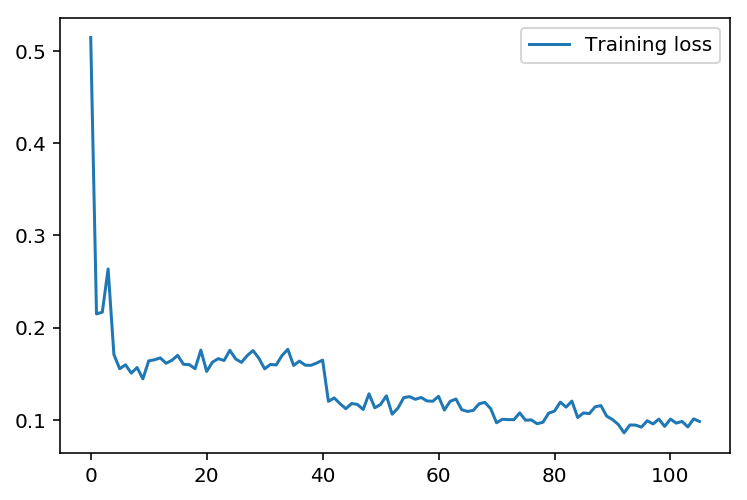

In [31]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，后面出现严重过拟合的情况

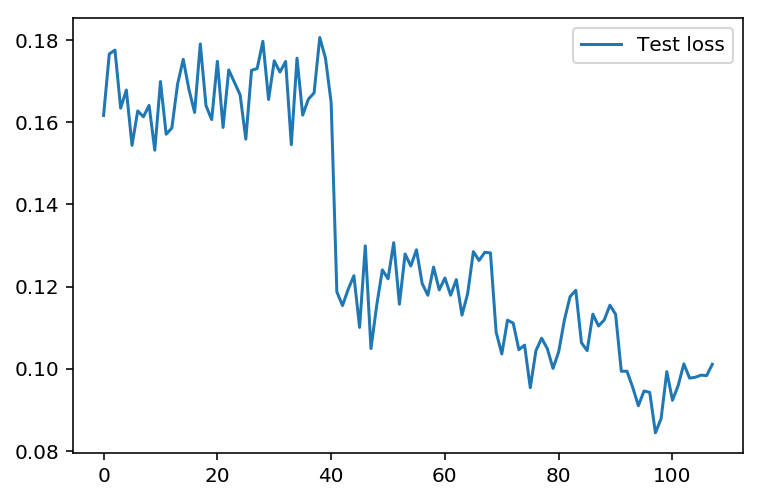

In [32]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 显示训练CTR AUC

[0.5161839769838186, 0.5117658097329134, 0.5189063202508207, 0.5104032253936024, 0.521789168073659, 0.5237445112738217, 0.522731808891755, 0.53202709123434, 0.5196459838731408, 0.5253740559737545]


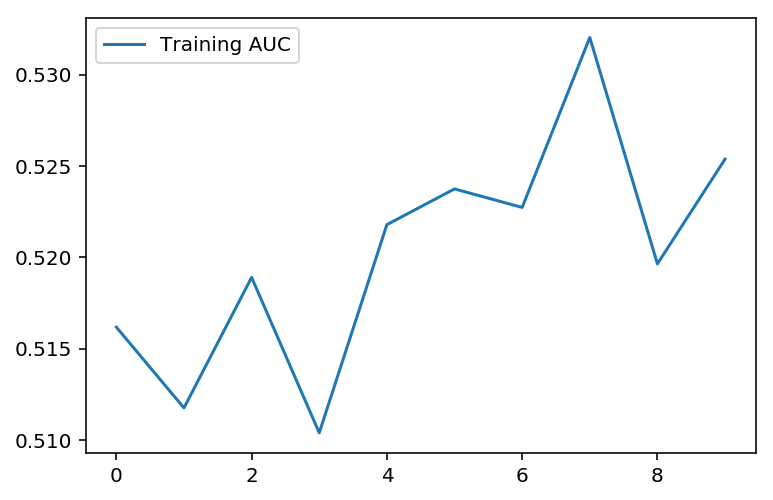

In [41]:
plt.plot(ctr_auc_stat['train'], label='Training AUC')
plt.legend()
_ = plt.ylim()
print(ctr_auc_stat['train'])

## 显示测试 CTR AUC

[0.5123415168930312, 0.5181202544226621, 0.5118893454286734, 0.5179461572090684, 0.5103899562904777, 0.5114842983101656, 0.5127123840570046, 0.5152115118345417, 0.5160927900364556, 0.5055662263365125]


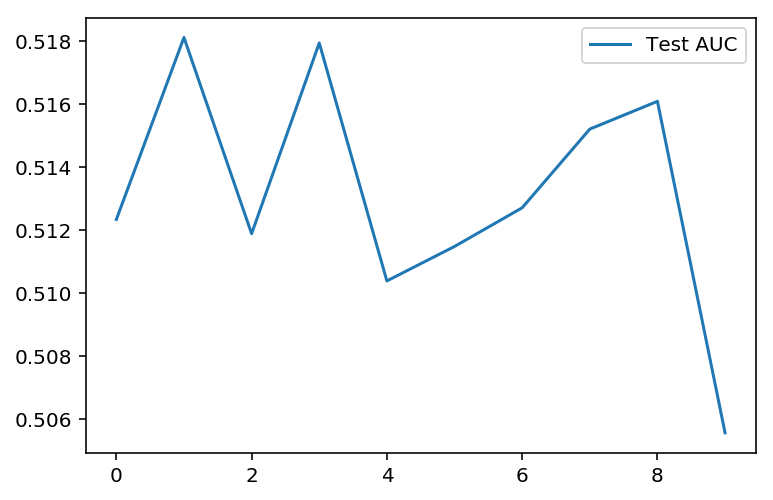

In [42]:
plt.plot(ctr_auc_stat['test'], label='Test AUC')
plt.legend()
_ = plt.ylim()
print(ctr_auc_stat['test'])

## 显示训练CVR AUC

[0.5401280984965041, 0.6122582612828861, 0.6178783529570986, 0.5851995481500338, 0.6073933835368475, 0.6253178794005125, 0.6201772959428584, 0.6223373282573238, 0.5910362016989552, 0.588819033387374]


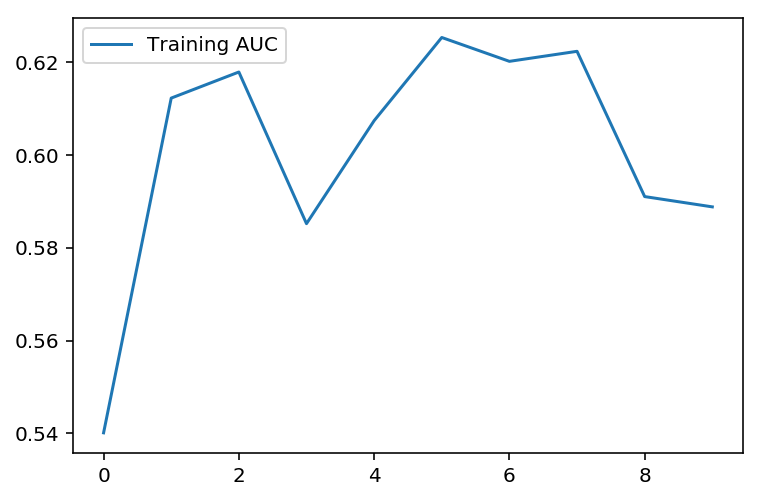

In [44]:
plt.plot(cvr_auc_stat['train'], label='Training AUC')
plt.legend()
_ = plt.ylim()
print(cvr_auc_stat['train'])

## 显示测试 CVR AUC

[0.5809140563662407, 0.5779704174509033, 0.5641753493333745, 0.5690819478986696, 0.592824313541559, 0.573535280578835, 0.5519904822270765, 0.5610070530937674, 0.5743199068974, 0.592629034170846]


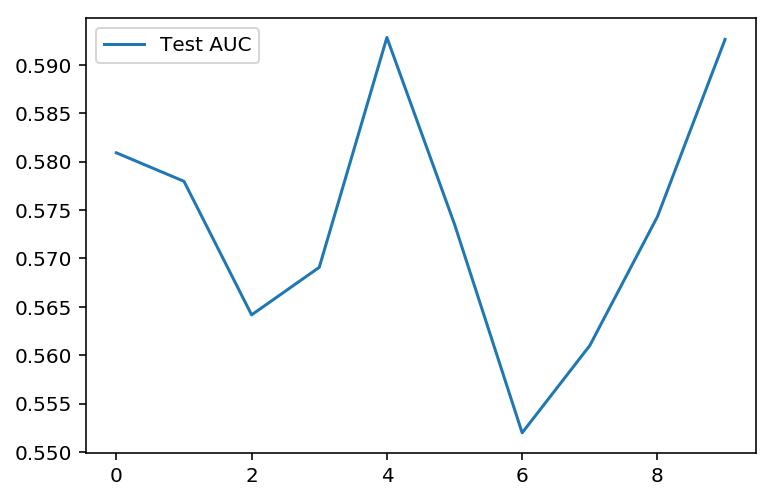

In [43]:
plt.plot(cvr_auc_stat['test'], label='Test AUC')
plt.legend()
_ = plt.ylim()
print(cvr_auc_stat['test'])

## 显示训练CTCVR AUC

[0.5128902691605606, 0.532075795384773, 0.5457531883723961, 0.5769622280903891, 0.6032472259188999, 0.5983725940969741, 0.6112578674478663, 0.6296309666198576, 0.6275287879924547, 0.615627333286109]


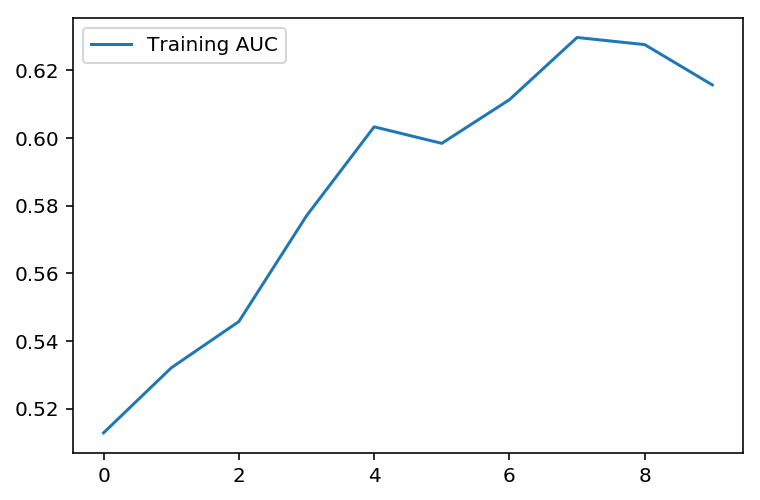

In [37]:
plt.plot(ctcvr_auc_stat['train'], label='Training AUC')
plt.legend()
_ = plt.ylim()
print(ctcvr_auc_stat['train'])

## 显示测试 CTCVR AUC

[0.6031050659215119, 0.6019742123924965, 0.5984874770681883, 0.6014554592415484, 0.6238518410570237, 0.6099320833912447, 0.5866625005669875, 0.5944490941047398, 0.5964984587467385, 0.625663789377129]


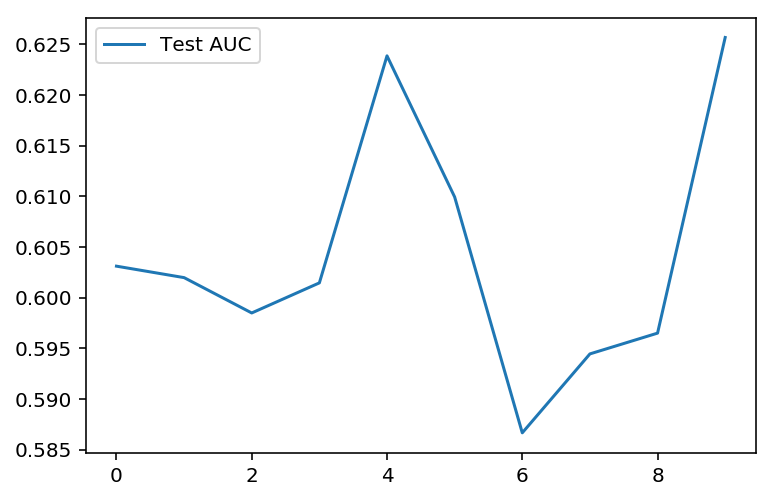

In [38]:
plt.plot(ctcvr_auc_stat['test'], label='Test AUC')
plt.legend()
_ = plt.ylim()
print(ctcvr_auc_stat['test'])

# 总结

ESMM模型利用用户行为序列数据在完整样本空间建模，避免了传统CVR模型经常遭遇的样本选择偏差和训练数据稀疏的问题，取得了显著的效果。另一方面，ESMM模型首次提出了利用学习CTR和CTCVR的辅助任务迂回学习CVR的思路。ESMM模型中的BASE子网络可以替换为任意的学习模型，因此ESMM的框架可以非常容易地和其他学习模型集成，从而吸收其他学习模型的优势，进一步提升学习效果，想象空间巨大。

# 引用
[1] Xiao Ma, Liqin Zhao, Guan Huang, Zhi Wang, Zelin Hu, Xiaoqiang Zhu, and Kun Gai. 2018. Entire Space Multi-Task Model: An Effective Approach for Estimating Post-Click Conversion Rate. SIGIR (2018).

今天的分享就到这里，请多指教！